In [2]:
# import torch
# Adapted from: Chapter 7 and 8 of Deep Learning with Pytorch by Eli Stevens (2020)

try:
    import torch as t
    import torch.nn as tnn
except ImportError:
    print("Colab users: pytorch comes preinstalled. Select Change Ru")
    print("Local users: Please install pytorch for your hardware using instructions from here: https://pytorch.org/get-started/locally/")
    print("ACG users: Please follow instructions here: https://vikasdhiman.info/ECE490-Neural-Networks/posts/0000-00-06-acg-slurm-jupyter/")
    
    raise

if t.cuda.is_available():
    DEVICE="cuda"
    t.cuda.set_device(t.device('cuda:0'))
else:
    DEVICE="cpu"

    
DTYPE = t.get_default_dtype()
print(f"Using {DEVICE=} and {DTYPE=}")

Using DEVICE='cuda' and DTYPE=torch.float32


In [3]:
# import other libraries
import torch.nn
import torch.optim
import torchvision
from torchvision.transforms import Compose, Normalize, Resize
from torchvision.transforms.functional import to_tensor
from torch.utils.data import DataLoader, Dataset
from glob import glob
from PIL import Image
import re
import random
import os
from pathlib import Path
import matplotlib.pyplot as plt
print("All libraries have been imported successfully!")

All libraries have been imported!


In [4]:
# Reference: https://github.com/yoctometric/biome_detector
# Define a new class BiomeDataset to read data according to the path
class BiomeDataset(Dataset):
    def __init__(self, data_dir: str, dir_is_paths=False, id_convert_dict=None):
        """
        Arguments:
            data_dir (str): Path to root data directory
            dir_is_paths (bool): If true, interprets data_dir as a list of images
        """
        # init transform to none
        self.transform = None

        if id_convert_dict is not None:
            self.id_to_class = id_convert_dict

        if dir_is_paths:
            self.paths = data_dir
            return
    
        # get the number of images in the dataset
        self.paths = glob(f"{data_dir}/*/*")
        dirs = glob(f"{data_dir}/*")

        self.id_to_class = {} # dictionary which converts a biome id to its class number
        self.data = []  # 2d array. First index indexes biome, second index indexes images
        for i, d in enumerate(dirs):
            self.data.append(glob(f"{d}/*"))
            self.id_to_class[int(re.search(r'[0-9]+', d)[0])] = i

        print(self.id_to_class) 
        print(len(self.id_to_class))   


    def split_data(self, percent_train: float, percent_val: float, seed: int):
        """
        Splits the Dataset per biome into three separate Datasets, 
        one for training, one for validation, and the remainder is for testing.
        """
        train = []
        val = []
        test = []

        # used for shuffling the data
        rand = random.Random(seed)
        
        for b in self.data:
            n_ims = len(b)
            rand.shuffle(b)
            ind1 = int(n_ims * percent_train)
            ind2 = int(n_ims * (percent_train +percent_val))
            train += b[:ind1]
            val += b[ind1:ind2]
            test += b[ind2:]

        return (BiomeDataset(train, dir_is_paths=True, id_convert_dict=self.id_to_class), 
            BiomeDataset(val, dir_is_paths=True, id_convert_dict=self.id_to_class),
            BiomeDataset(test, dir_is_paths=True, id_convert_dict=self.id_to_class))


    def set_transform(self, transform):
        """
        updates the transform that the dataset will use when transforming images
        """
        self.transform = transform


    def __getitem__(self, idx):
        """
        Returns a tuple of (image: ndarray, label: int)
        """

        imname = self.paths[idx]
        image = Image.open(imname)
        image = to_tensor(image).cuda()  # converts to float tensor
        # apply transforms
        if self.transform is not None:
            image = self.transform(image)
    
        label = int(re.search(r'[0-9]+', imname)[0])
        label = self.id_to_class[label]
        return (image, label)


    def __len__(self):
        return len(self.paths)


Modify or add the following dataset path for your dataset!!!

In [6]:
# TODO: Change the path for your dataset
Serendipity_path = 'C:/Users/潘末锴/Desktop/CS182 Project/data'

In [23]:
# Read the data in the directory.
Data = BiomeDataset(Serendipity_path)
Train_percentage = 0.5
Val_percentage = 0.25
seed = 42
Test_percentage = 1 - (Train_percentage + Val_percentage)
Splitted_data = Data.split_data(Train_percentage, Val_percentage, seed)
train_data = Splitted_data[0]
val_data = Splitted_data[1]
test_data = Splitted_data[2]
print(len(train_data), len(val_data), len(test_data))
print(train_data[0][0].shape)

{182: 40}
1
11084 5531 5554
torch.Size([3, 180, 320])


iteration_time: 2


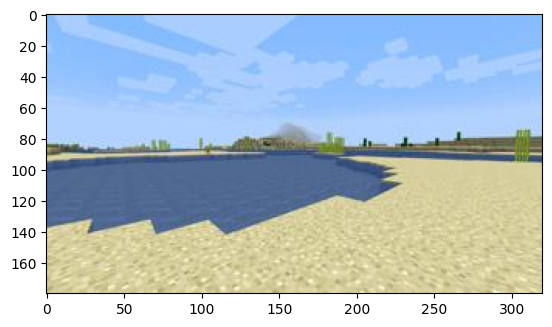

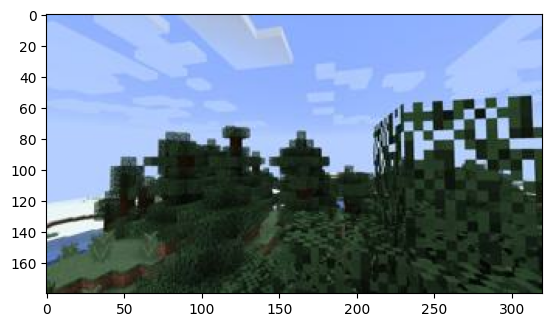

In [46]:
# Some examples in the dataset
iteration_time = random.randint(1,3)
print('iteration_time:',iteration_time)
for i in range(iteration_time):
    ran = random.randint(1,22168)
    im, label = Data[ran]
    plt.imshow(im.cpu().permute(1, 2, 0))
    plt.show()